In [1]:
import pandas as pd
import numpy as np

# Beschreibung des Ausgangsproblems

* Prinzipiell handelt es ich bei dem Problem um die Verknüpfung eines Produktions- und Distributionsproblems (DP). Da das Distributionsproblem komplexer erscheint, wird zunächst die Lösung des DP'S behandelt


* Bei dem DP handelt es sich um ein multiple Traveling Salesman Problem. 
* Demnach gibt es keine Beschränkung der Fahrzeugkapazität, es gibt mehrere Fahrzeuge (multiple) und die Fahrzeuge starten und enden am gleichen Punkt (in unserem Fall Leipzig)



* Für die erste Modellformulierung wird zunächst ein Modell erstellt, welches über die Knoten (Städte) mehrfach besuchen kann. Es soll bei der Modellierung untersucht werden, ob die Fahrzeuge die Kunden mehrfach anfahren können und alle Kunden in der vorgesehen Zeit $t_i$ im Rahmen von $a_{min}<t_i<a_{max}$ angefahren werden. Falls dies nicht so ist, soll der Strafkosten Satz $M$ pro Kunden $i$ erhoben werden. 

In [92]:
#in case no visualisation possible,  'brew install graphviz' might solve the problem

from graphviz import Digraph

dot = Digraph(comment='The Round Table')

dot.node('A', 'Startdepot (i=0)')


with dot.subgraph(name='cluster_1') as c:

    c.node('B', 'Stadt 1')
    c.node('C', 'Stadt 2')
    c.node('D', 'Stadt i')
    c.attr(label='customer nodes')
    c.attr(color='blue')

dot.node('E', 'Enddepot (i=n+1)')


dot.edges(['AB','BC','CD','DE'])
dot.edge('A','E',label="\t LEERFAHRT \n \t Keine Strecke oder Zeit")

dot.save("Leefahrt.png")

'test.pdf'

# Modellformulierung 

## Zielfunktion

Network is respected as a Graph $G (N,E) $ with N set of nodes and the set of edges $E \subseteq N x N $

Edge is represented as a flow $i$ -> $j$ 

Node N+1 ist gleich Node 0, --> eingefügt um Leerfahrten zu berücksichtigen


 $$ min  \sum_{i\in V}\sum_{j\in V} c_{i,j,k,r}x_{i,k,r}+carroute_{k,r}*1000 +\frac{10} {60} * \sum_{i\in V^{+}, k \in K, r \in R} {t_{i,k,r}}   $$ Distribution
 
 $$ + M * \sum_{i\in V, njob \in Jobs} {m_{i,njob}} $$ Strafkosten
 
 $$ + 1200 * \sum_{type \in Types, p \in Prodlines } {prodrel_{p,type,k}* proddur_{type}} $$ Produktion
 
 
 --> Variable Kosten der Fahrt 
 --> Fixkosten noch nicht implementiert

## Nebenbedingungen

### Flow constraints

$$ \sum_{i \in V^{+}} {x_{0,i,k,r}}   = 1  \quad \forall r,k \quad\quad (1) $$ 

$$ \sum_{i \in V^{+}} {x_{i,N+1,k,r}}   = 1  \quad \forall r,k  \quad \quad   (2) $$ 

$$ \sum_{i \in V^{+}} {x_{i,h,k,r}}   = \sum_{j \in V^{+}} {x_{h,j,k,r}}   \quad \forall h \in V, r,k \quad \quad   (3) $$ 

$$ \sum_{j \in V^{+}} {x_{i,j,k,r}}   =  y_{i,k,r}   \quad \forall i \in V^{+}, r,k \quad \quad   (4) $$ 

### Time constraints

$$ t_{i,k,r} + T_{i,j} - bigM * ( {1-x_{i,j,k,r}} ) \leq t_{j,k,r}   \quad \forall i,j \in V^{+}, r,k \quad \quad   (5) $$ 

$T_{ij}$ ist die Dauermatrix von i zu j  

### Production

$$ \sum_{type,p} {prodrel_{p,type,k,r}}   =  1   \quad \forall r,k \quad \quad   (6) $$ 

maximal ein Knoten pro Autoroute

$$ prodstart_{k,r}  + \sum_{type,p} {prodrel_{p,type,k,r} * Proddur_{type}} \leq  t_{0,k,r}   \quad \forall r,k \quad \quad   (7) $$ 

### Radioaktivität

$$ \sum_{type,p} {prodrel_{p,type,k,r}} * Radstart_{type} - bigM * (1-j_{i,njob,k,r})  \leq A_{i,njob} - t_{0,k,r} \leq \sum_{type,p} {prodrel_{p,type,k,r}} * Radend_{type} + bigM * (1-j_{i,njob,k,r})   \quad \forall i \in V,r,k,njob \quad \quad   (8) $$ 

Radstart und Radend bezeichnen die Grenzen der Radioaktivität als Funktion der Zeit mithilfe von 

$$ Radend_{type} = \frac {\ln{\frac {max } {val_{type}}} } {\ln {0.85}*30} $$
$$ Radstart_{type} = \frac {\ln{\frac {min } {val_{type}}} } {\ln {0.85}*30} $$



### Jobs der Knoten

$$ t_{i,k,r} \leq c_{i,njob,k,r} \leq A_{i,njob} - 30.0 - S_{j}    \quad \forall i \in V,r,k,njob \quad \quad   (9) $$ 

$$ \sum_{njob} {j_{i,njob,k,r}} \geq y_{i,k,r}    \quad \forall i \in V,r,k \quad \quad   (10) $$ 

$$ \sum_{njob} {j_{i,njob,k,r}} \leq 1    \quad \forall i \in V,r,k \quad \quad   (11) $$ 

$$ {j_{i,njob,k,r}} \leq y_{i,k,r}    \quad \forall i \in V,r,k,njob \quad \quad   (12) $$ 

### Routenbedingung

$$  {t_{N+1,k,r}} \leq t_{0,k,r+1}    \quad \forall r,k \quad \quad   (13) $$ 

Routenbedingung--> erst nächste Route starten, wenn wieder im Depot angekommen

$$  carroute_{k,r} = \sum_{i,j \in V} {x_{0,j,k,r} }    \quad \forall r,k \quad \quad   (14) $$ 

zeigt ob Leerroute

 $$ x_{ij} \in \mathbb{R}^{*} \Leftrightarrow  \sum_{i,j} {x_{ij} * distance_{ij} } \leq upperlimit-lowerlimit \approx 204 $$

# Daten für das Modell

In [5]:
import os
used_vars=[]
for file in os.listdir(os.getcwd()):
    if file.endswith(".txt"):
        print file.split(".txt")[0]
        var_name =file.split(".txt")[0]
        name = []
                
        file = open(file, 'r') 
        file_cont= file.read() 
        for line in file_cont:
            name.append(line.split(' '))
        file.close()
        used_vars.append(name)
#print(used_vars)






a_m
c
c_PF
cp
J
L_ij
M_F
m_t
m_v
P
production_line_parameters
S_j
t
T_ij
T_ij2
T_ij3
V


In [6]:
import os
used_vars=[]
for file in os.listdir(os.getcwd()):
    if file.endswith(".txt"):
        print file.split(".txt")[0]
        var_name =file.split(".txt")[0]
        name = []
                
        file = open(file, 'r') 
        file_cont= file.read() 
        for line in file_cont:
            name.append(line.split(' '))
        file.close()
        used_vars.append(name)
#print(used_vars)






a_m
c
c_PF
cp
J
L_ij
M_F
m_t
m_v
P
production_line_parameters
S_j
t
T_ij
T_ij2
T_ij3
V


In [7]:
S_j=pd.read_csv('S_j.txt', sep=" ")
S_j=S_j.iloc[:,0:2]
S_j.columns=['j', 'Wert']
S_j

,j,Wert
0,0,15
1,1,30
2,2,30
3,3,15
4,4,30
5,5,15
6,6,30
7,7,15


In [8]:
S_j=np.vstack([S_j,[8,0]])
S_j

array([[ 0, 15],
       [ 1, 30],
       [ 2, 30],
       [ 3, 15],
       [ 4, 30],
       [ 5, 15],
       [ 6, 30],
       [ 7, 15],
       [ 8,  0]])

In [9]:
S_j=S_j[:,-1]
S_j

array([15, 30, 30, 15, 30, 15, 30, 15,  0])

## Get the duration matrix $T_{ij}$

In [10]:
import pandas as pd
import numpy as np

data = pd.read_csv('T_ij3.txt', sep="\t")
data['T_ij']=pd.to_datetime(data['T_ij'],format='%H:%M').dt.hour*60+pd.to_datetime(data['T_ij'],format='%H:%M').dt.minute

In [11]:
data=data.pivot(index='i',columns='j')

In [12]:
data.columns

MultiIndex(levels=[[u'T_ij'], [1, 2, 3, 4, 5, 6, 7]],
           labels=[[0, 0, 0, 0, 0, 0, 0], [0, 1, 2, 3, 4, 5, 6]],
           names=[None, u'j'])

In [13]:
data.columns=data.columns.droplevel()

In [14]:
data.insert(0,0,np.nan) #insert missing column


In [15]:
data.loc[len(data)]=np.nan # insert missing row

In [16]:
data

j,0,1,2,3,4,5,6,7
i,,,,,,,,
0,NaN,59.0,80.0,88.0,75.0,86.0,75.0,87.0
1,NaN,NaN,96.0,134.0,65.0,82.0,112.0,66.0
2,NaN,NaN,NaN,70.0,52.0,24.0,133.0,136.0
3,NaN,NaN,NaN,NaN,100.0,76.0,129.0,168.0
4,NaN,NaN,NaN,NaN,NaN,39.0,124.0,107.0
5,NaN,NaN,NaN,NaN,NaN,NaN,135.0,123.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data=data.fillna(0) #replace nan values with 0

In [18]:
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

class SymNDArray(np.ndarray):
    def __setitem__(self, (i, j), value):
        super(SymNDArray, self).__setitem__((i, j), value)                    
        super(SymNDArray, self).__setitem__((j, i), value)                    

def symarray(input_array):
    """
    Returns a symmetrized version of the array-like input_array.
    Further assignments to the array are automatically symmetrized.
    """
    return symmetrize(np.asarray(input_array)).view(SymNDArray)



In [19]:
data=symarray(data)

In [20]:
T_ij=data[:]

In [21]:
T_ij=np.vstack([T_ij,np.zeros(8)])
T_ij=np.c_[T_ij,np.zeros(9)]

In [22]:
T_ij[-1]=T_ij[:,0]
T_ij

array([[   0.,   59.,   80.,   88.,   75.,   86.,   75.,   87.,    0.],
       [  59.,    0.,   96.,  134.,   65.,   82.,  112.,   66.,    0.],
       [  80.,   96.,    0.,   70.,   52.,   24.,  133.,  136.,    0.],
       [  88.,  134.,   70.,    0.,  100.,   76.,  129.,  168.,    0.],
       [  75.,   65.,   52.,  100.,    0.,   39.,  124.,  107.,    0.],
       [  86.,   82.,   24.,   76.,   39.,    0.,  135.,  123.,    0.],
       [  75.,  112.,  133.,  129.,  124.,  135.,    0.,  118.,    0.],
       [  87.,   66.,  136.,  168.,  107.,  123.,  118.,    0.,    0.],
       [   0.,   59.,   80.,   88.,   75.,   86.,   75.,   87.,    0.]])

In [23]:
T_ij[:,-1]=T_ij[:,0]
T_ij

array([[   0.,   59.,   80.,   88.,   75.,   86.,   75.,   87.,    0.],
       [  59.,    0.,   96.,  134.,   65.,   82.,  112.,   66.,   59.],
       [  80.,   96.,    0.,   70.,   52.,   24.,  133.,  136.,   80.],
       [  88.,  134.,   70.,    0.,  100.,   76.,  129.,  168.,   88.],
       [  75.,   65.,   52.,  100.,    0.,   39.,  124.,  107.,   75.],
       [  86.,   82.,   24.,   76.,   39.,    0.,  135.,  123.,   86.],
       [  75.,  112.,  133.,  129.,  124.,  135.,    0.,  118.,   75.],
       [  87.,   66.,  136.,  168.,  107.,  123.,  118.,    0.,   87.],
       [   0.,   59.,   80.,   88.,   75.,   86.,   75.,   87.,    0.]])

## Get the Travel Costs $ c_{ij} $

$c_{ij}$ ist definiert als die Kosten vom Ort $i$ zum Ort $j$. Hierfür ist es notwendig die Distanzmatrix mit meilenspezifischen Kosten $m$ [€/ml] zu multiplizieren sowie die Spritkosten $f$ zu berücksichtigen. Der additive $g$ ist der Teil, den die Fahrer für sich beanspruchen. Mathematisch also $$ c_{ij}=(m+f)d{ij}+g $$

In [24]:
L_ij = pd.read_csv('L_ij.txt', sep=" ")
m_v=5
m_t=10
M_F=1000

In [25]:
L_ij=L_ij.pivot(index='i',columns='j')
L_ij.columns=L_ij.columns.droplevel()
L_ij.insert(0,0,np.nan) #insert missing column
L_ij.loc[len(L_ij)]=np.nan # insert missing row
L_ij=L_ij.fillna(0) #replace nan values with 0
L_ij

j,0,1,2,3,4,5,6,7
i,,,,,,,,
0,0.0,47.0,57.0,83.0,70.0,53.0,74.0,89.0
1,0.0,0.0,96.0,127.0,63.0,84.0,103.0,64.0
2,0.0,0.0,0.0,50.0,45.0,14.0,119.0,139.0
3,0.0,0.0,0.0,0.0,94.0,67.0,121.0,169.0
4,0.0,0.0,0.0,0.0,0.0,33.0,125.0,107.0
5,0.0,0.0,0.0,0.0,0.0,0.0,138.0,127.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
L_ij=symarray(L_ij)
L_ij
L_ij=np.vstack([L_ij,np.zeros(8)])
L_ij=np.c_[L_ij,np.zeros(9)]
L_ij[-1]=L_ij[:,0]
L_ij[:,-1]=L_ij[:,0]
L_ij

array([[   0.,   47.,   57.,   83.,   70.,   53.,   74.,   89.,    0.],
       [  47.,    0.,   96.,  127.,   63.,   84.,  103.,   64.,   47.],
       [  57.,   96.,    0.,   50.,   45.,   14.,  119.,  139.,   57.],
       [  83.,  127.,   50.,    0.,   94.,   67.,  121.,  169.,   83.],
       [  70.,   63.,   45.,   94.,    0.,   33.,  125.,  107.,   70.],
       [  53.,   84.,   14.,   67.,   33.,    0.,  138.,  127.,   53.],
       [  74.,  103.,  119.,  121.,  125.,  138.,    0.,  121.,   74.],
       [  89.,   64.,  139.,  169.,  107.,  127.,  121.,    0.,   89.],
       [   0.,   47.,   57.,   83.,   70.,   53.,   74.,   89.,    0.]])

In [27]:
c_ij=L_ij*m_v
c_ij

array([[   0.,  235.,  285.,  415.,  350.,  265.,  370.,  445.,    0.],
       [ 235.,    0.,  480.,  635.,  315.,  420.,  515.,  320.,  235.],
       [ 285.,  480.,    0.,  250.,  225.,   70.,  595.,  695.,  285.],
       [ 415.,  635.,  250.,    0.,  470.,  335.,  605.,  845.,  415.],
       [ 350.,  315.,  225.,  470.,    0.,  165.,  625.,  535.,  350.],
       [ 265.,  420.,   70.,  335.,  165.,    0.,  690.,  635.,  265.],
       [ 370.,  515.,  595.,  605.,  625.,  690.,    0.,  605.,  370.],
       [ 445.,  320.,  695.,  845.,  535.,  635.,  605.,    0.,  445.],
       [   0.,  235.,  285.,  415.,  350.,  265.,  370.,  445.,    0.]])

In [28]:
c_ij=c_ij.tolist()

## Demand times

In [29]:
from datetime import datetime
import pandas as pd

t_io = []

with open("t.txt", "r") as f:
    for cnt,line in enumerate(f):
        if cnt==0:
            t_io=[]
            pass
        
        elif cnt==1:
            val_line=line.split(" 0 ")[0].strip().split(" ")
            t_io=[[datetime.strptime(x, "%H:%M").hour*60+datetime.strptime(x, "%H:%M").minute for x in val_line[1:]]]
            #print(t_io)
            
        else:
            val_line=line.split(" 0 ")[0].strip().split(" ")
            t_io.append([datetime.strptime(x, "%H:%M").hour*60+datetime.strptime(x, "%H:%M").minute for x in val_line[1:]])
            
#print(t_io)
df=pd.DataFrame(t_io)


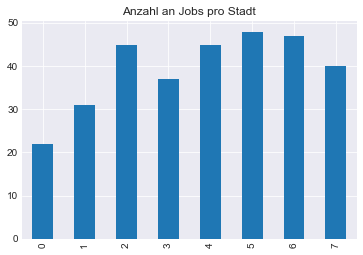

In [30]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
df.count(axis=1).plot(kind='bar')
plt.title('Anzahl an Jobs pro Stadt')

plt.show()

In [31]:
df.loc[8]=0

In [32]:
a=df[:]

## Ergebnisvisualisierung

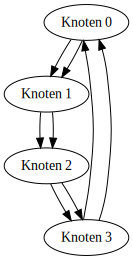

In [93]:
    #function for plotting the results
    def plotdigraph(data):
        #data is dictionary of positive nodes

        dot = Digraph(comment='The Round Table')

        for d in data:
            dot.node(str(d[0]),"Knoten "+str(d[0]))
            dot.node(str(d[1]),"Knoten "+str(d[1]))
            dot.edge(str(d[0]),str(d[1]))

            dot.render(filename='img/Ergebnis')
        return dot

    data=[[0,1],[1,2],[2,3],[3,0],[0,1],[1,2],[2,3],[3,0]]
    plotdigraph(data)


## Add the demand constraints

##### $a_{min}$ und $a_{max}$ werden zunächst als Konstante +- 10 min angenommen

In [34]:
amin=T_ij[:]
amin=amin-10
amin[np.diag_indices_from(amin)]=amin[np.diag_indices_from(amin)]+10

amax=T_ij[:]
amax=amax+40
amax[np.diag_indices_from(amax)]=amax[np.diag_indices_from(amax)]-10

In [35]:
amin

array([[   0.,   49.,   70.,   78.,   65.,   76.,   65.,   77.,  -10.],
       [  49.,    0.,   86.,  124.,   55.,   72.,  102.,   56.,   49.],
       [  70.,   86.,    0.,   60.,   42.,   14.,  123.,  126.,   70.],
       [  78.,  124.,   60.,    0.,   90.,   66.,  119.,  158.,   78.],
       [  65.,   55.,   42.,   90.,    0.,   29.,  114.,   97.,   65.],
       [  76.,   72.,   14.,   66.,   29.,    0.,  125.,  113.,   76.],
       [  65.,  102.,  123.,  119.,  114.,  125.,    0.,  108.,   65.],
       [  77.,   56.,  126.,  158.,   97.,  113.,  108.,    0.,   77.],
       [ -10.,   49.,   70.,   78.,   65.,   76.,   65.,   77.,    0.]])

In [36]:
amax

array([[  30.,   99.,  120.,  128.,  115.,  126.,  115.,  127.,   40.],
       [  99.,   30.,  136.,  174.,  105.,  122.,  152.,  106.,   99.],
       [ 120.,  136.,   30.,  110.,   92.,   64.,  173.,  176.,  120.],
       [ 128.,  174.,  110.,   30.,  140.,  116.,  169.,  208.,  128.],
       [ 115.,  105.,   92.,  140.,   30.,   79.,  164.,  147.,  115.],
       [ 126.,  122.,   64.,  116.,   79.,   30.,  175.,  163.,  126.],
       [ 115.,  152.,  173.,  169.,  164.,  175.,   30.,  158.,  115.],
       [ 127.,  106.,  176.,  208.,  147.,  163.,  158.,   30.,  127.],
       [  40.,   99.,  120.,  128.,  115.,  126.,  115.,  127.,   30.]])

### Get hypothetical distance matrix

In [37]:
'''

n=8
distances=[]
vals=[]
for i in range(n+1):
    for j in range(n+1):
        val=(distance(points,i,j))
        vals.append(val)
    distances.append(vals)
    vals=[]
distances[0:2] #

'''

'\n\nn=8\ndistances=[]\nvals=[]\nfor i in range(n+1):\n    for j in range(n+1):\n        val=(distance(points,i,j))\n        vals.append(val)\n    distances.append(vals)\n    vals=[]\ndistances[0:2] #\n\n'

In [38]:
#print("""Prinzipiell gibt es %s Knoten. Im Beispiel sind allerdings bereits %s vorhanden,
#wobei der letzte im Beispiel das Depot ist. Daher wird der letzte fuer Testzwecke ueberschrieben. Eine Seite
#zu veraendern ist ausreichend, da Symmetrie in Objektklasse vorhanden""" % (len(amax), len(points)))

In [39]:
amin[:,-1]=np.repeat(0,len(amin[:,1]))
amin

array([[   0.,   49.,   70.,   78.,   65.,   76.,   65.,   77.,    0.],
       [  49.,    0.,   86.,  124.,   55.,   72.,  102.,   56.,    0.],
       [  70.,   86.,    0.,   60.,   42.,   14.,  123.,  126.,    0.],
       [  78.,  124.,   60.,    0.,   90.,   66.,  119.,  158.,    0.],
       [  65.,   55.,   42.,   90.,    0.,   29.,  114.,   97.,    0.],
       [  76.,   72.,   14.,   66.,   29.,    0.,  125.,  113.,    0.],
       [  65.,  102.,  123.,  119.,  114.,  125.,    0.,  108.,    0.],
       [  77.,   56.,  126.,  158.,   97.,  113.,  108.,    0.,    0.],
       [ -10.,   49.,   70.,   78.,   65.,   76.,   65.,   77.,    0.]])

In [40]:
amax[:,-1]=np.repeat(1000,len(amax[:,1])) #sufficiently large 
amax

array([[   30.,    99.,   120.,   128.,   115.,   126.,   115.,   127.,
         1000.],
       [   99.,    30.,   136.,   174.,   105.,   122.,   152.,   106.,
         1000.],
       [  120.,   136.,    30.,   110.,    92.,    64.,   173.,   176.,
         1000.],
       [  128.,   174.,   110.,    30.,   140.,   116.,   169.,   208.,
         1000.],
       [  115.,   105.,    92.,   140.,    30.,    79.,   164.,   147.,
         1000.],
       [  126.,   122.,    64.,   116.,    79.,    30.,   175.,   163.,
         1000.],
       [  115.,   152.,   173.,   169.,   164.,   175.,    30.,   158.,
         1000.],
       [  127.,   106.,   176.,   208.,   147.,   163.,   158.,    30.,
         1000.],
       [   40.,    99.,   120.,   128.,   115.,   126.,   115.,   127.,
         1000.]])

## Pretty Print the variable results

In [41]:
def pretty_result(var):
    test=[]
    for ac in var.values():

        #solarray.append(ac.X>0)
        res= [ad for ad in ac.VarName.split("_"),[ac.X]]
        flat_list = [item for sublist in res for item in sublist]

        test.append(flat_list)
        #if ac.X>0:
        #    pass

    return pd.DataFrame(test)


In [42]:
def printvars():
    
    #which paths are used by vehicles? 
    x=pretty_result(vars)
    x.columns=('varname','Anfang', 'Ende', 'Route', 'Ergebnis')
    x=x.sort_values(['Route','Anfang'], ascending=True)
    x.head(12)
    x[x.Ergebnis>0]
    
    
    #which customers are not served?

    mdf=pretty_result(mvar)
    mdf.columns=('varname','Knoten', 'Job', 'Ergebnis')
    mdf=mdf.sort_values(['Knoten'], ascending=True)
    #mdf.head(12)
    print(" %d Prozent der Auftraege wurden beliefert" % ( 100* (len(mdf[mdf.Ergebnis==0]))/float(len(mdf)) ) )
    

    #which nodejob is in which route?
    y=pretty_result(yvar)
    y.columns=('varname','Knoten', 'Job', 'Route', 'Ergebnis')
    y=y.sort_values(['Route','Knoten'], ascending=True)
    y.head(12)
    y[y.Ergebnis>0]
    
    
    #when is which job treated?

    t=pretty_result(tvar)
    t.columns=('varname','Knoten', 'Job', 'Route', 'Ergebnis')
    t=t.sort_values(['Ergebnis'], ascending=True)
    t.head(12)
    t[t.Ergebnis>0]


    
    
    return x,mdf,y,t
#x,mdf,y=printvars()

In [43]:
#08:00 beginnen die Daten--> Festlegen auf 0
#bis 17:45

FMT = '%H:%M'
tdelta = datetime.strptime("17:45", FMT) - datetime.strptime("08:00", FMT)
tdelta/60 # amount of indexes for t if integer inteverals are assumed--> amount of: y=*5, x=*5, t=*5 --> enormous! 

datetime.timedelta(0, 585)

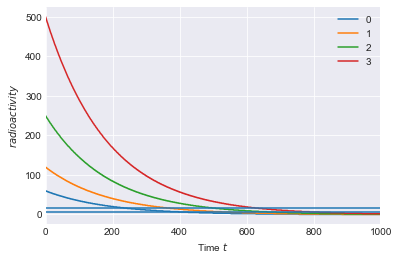

,0,1,2,3
0,60,120,250,500
1,59,119,248,497
2,59,118,247,494
3,59,118,245,491
4,58,117,244,489


In [44]:
import matplotlib.pyplot as pylab
e_start=[60,120,250,500] #radioactivity of the beginning
t_int=np.arange(0,1000)/30.0 #in minutes
t_int=[[e] for e in t_int]
e_t=np.dot(np.array([[e] for e in e_start]),0.85**(np.transpose(t_int))) 
#plt.plot(e_t)
#plt.show()

#hint--> np.int(4.9)=4 --> increases disk space

a_t=pd.DataFrame(np.array(e_t,np.int)).T

a_t.plot()
pylab.xlabel("Time $t$")
pylab.ylabel("$ radioactivity $")


plt.axhline(5)
plt.axhline(15)
plt.show()
a_t.head()





## Remove Non-linearity
$$ radioactivity_{t+1} = 0.85^{\frac t {30}}*StartRadioactivity_{productionUnit}$$
$$  \ln (radioactivity_{t+1}) = \frac t {30}*\ln(0.85)+\ln(StartRadioactivity_{productionUnit}) $$

--> constraint has to be: $$ \ln (5) \leq \ln (radioactivity_{t}) \leq \ln (15) $$

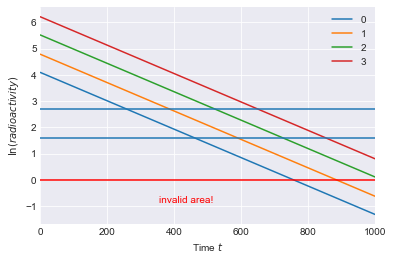

In [45]:
from matplotlib import pyplot, pylab

e_start=[60,120,250,500] #radioactivity of the beginning
t_int=np.arange(0,1000)/30.0 #in minutes
t_int=[[e] for e in t_int]
e_t=np.dot(np.array([[e] for e in e_start]),0.85**(np.transpose(t_int)))
pd.DataFrame(np.log(e_t)).T.plot()

plt.axhline(np.log(15))
plt.axhline(np.log(5))
plt.axhline(0,color='r')
plt.figtext(0.4,0.2,'invalid area!',color='r')
pylab.xlabel("Time $t$")
pylab.ylabel("$ \ln (radioactivity) $")


#plt.xlabel('xlabel', fontsize=18)

plt.show()


## Remove Negativity
$$ radioactivity_{t+1} = 0.85^{\frac t {30}}*StartRadioactivity_{productionUnit}$$
$$  \ln (radioactivity_{t+1}) = \frac t {30}*\ln(0.85)+\ln(StartRadioactivity_{productionUnit}) $$

--> constraint has to be: $$ \ln (5) + bigM \leq \ln (radioactivity_{t}) \leq \ln (15) + bigM $$

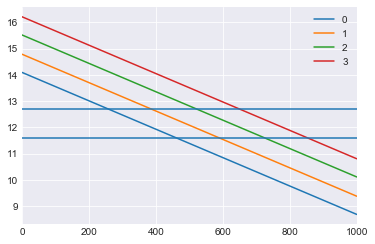

,0,1,2,3
0,14.094345,14.787492,15.521461,16.214608
1,14.088927,14.782074,15.516044,16.209191
2,14.083510,14.776657,15.510626,16.203774
3,14.078093,14.771240,15.505209,16.198356
4,14.072675,14.765823,15.499792,16.192939


In [46]:
e_start=[60,120,250,500] #radioactivity of the beginning
t_int=np.arange(0,1000)/30.0 #in minutes
t_int=[[e] for e in t_int]
e_t=np.dot(np.array([[e] for e in e_start]),0.85**(np.transpose(t_int)))

a_t=pd.DataFrame(np.array(e_t)).T


test=np.log(a_t)+10
test.plot()


plt.axhline(np.log(15)+10)
plt.axhline(np.log(5)+10)


plt.show()
test.head()

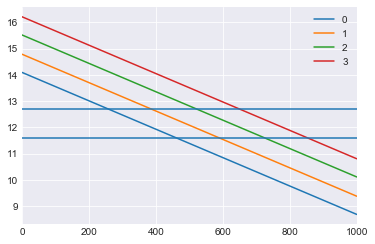

,0,1,2,3
0,14.094345,14.787492,15.521461,16.214608
1,14.088927,14.782074,15.516044,16.209191
2,14.083510,14.776657,15.510626,16.203774
3,14.078093,14.771240,15.505209,16.198356
4,14.072675,14.765823,15.499792,16.192939


In [47]:
e_t=np.dot(np.array([[e] for e in e_start]),0.85**(np.transpose(t_int)))

a_t=pd.DataFrame(np.array(e_t)).T



test=np.log(a_t)+10
test.plot()


plt.axhline(np.log(15)+10)
plt.axhline(np.log(5)+10)


plt.show()
test.head()

In [48]:
from scipy import stats
df=test[:]
#y = pd.np.r_[df[0], df[1], df[2], [df[3]]]
df.insert(0,'time',df.index.values)
#df['time']=df.index.values


time = df[['time']]

slopes=pd.DataFrame(np.linalg.pinv(time.T.dot(time)).dot(time.T).dot(df.fillna(0)),
             ['Slope'], df.columns.values)



#slope, intercept, r_value, p_value, std_err = stats.linregress(df.index,y)
#print(r_value)
#print(slope, intercept)

#slopes[1]*df.time.values
slopes

,time,0,1,2,3
Slope,1.0,0.015735,0.016775,0.017877,0.018917


In [49]:
df.head()

,time,0,1,2,3
0,0,14.094345,14.787492,15.521461,16.214608
1,1,14.088927,14.782074,15.516044,16.209191
2,2,14.083510,14.776657,15.510626,16.203774
3,3,14.078093,14.771240,15.505209,16.198356
4,4,14.072675,14.765823,15.499792,16.192939


-1.0
0.0
(-0.0054172976499258316, 14.787491742782045)


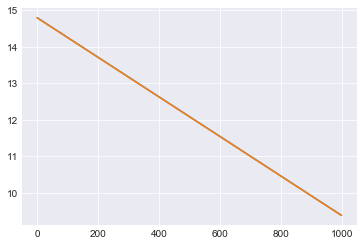

In [50]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df.index,df[1])
print(r_value)
print(std_err)
print(slope, intercept)
plt.plot(slope*df.index+intercept)
plt.plot(df[1])
plt.show()

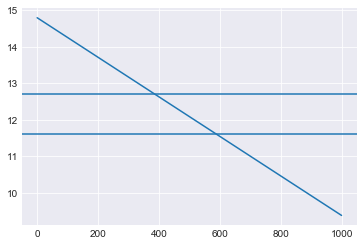

In [51]:
plt.plot(slope*df.index+intercept)
plt.axhline(np.log(15)+10)
plt.axhline(np.log(5)+10)
plt.show()

In [52]:

def printvars2():
    
    #which paths are used by vehicles? 
    x=pretty_result(vars)
    x.columns=('varname','Anfang', 'Ende', 'Route', 'Ergebnis')
    x=x.sort_values(['Route','Anfang'], ascending=True)
    x.head(12)
    x[x.Ergebnis>0]
    
    #which customers are not served?

    mdf=pretty_result(mvar)
    mdf.columns=('varname','Knoten', 'Job', 'Ergebnis')
    mdf=mdf.sort_values(['Knoten'], ascending=True)
    #mdf.head(12)
    print(" %d Prozent der Auftraege wurden beliefert" % ( 100* (len(mdf[mdf.Ergebnis==0]))/float(len(mdf)) ) )
    

    #which nodejob is in which route?
    y=pretty_result(yvar)
    y.columns=('varname','Knoten', 'Route', 'Ergebnis')
    y=y.sort_values(['Route','Knoten'], ascending=True)
    y.head(12)
    y[y.Ergebnis>0]
    
    
    #when is which job treated?

    t=pretty_result(tvar)
    t.columns=('varname','Knoten',  'Route', 'Ergebnis')
    t=t.sort_values(['Ergebnis'], ascending=True)
    t.head(12)
    t[t.Ergebnis>0]
    
    c=pretty_result(cvar)
    c.columns=('varname','Knoten', 'Job', 'Route', 'Ergebnis')
    c=c.sort_values(['Ergebnis'], ascending=True)
    c.head(12)
    c[c.Ergebnis>0]
    
    j=pretty_result(jvar)
    j.columns=('varname','Knoten', 'Job', 'Route', 'Ergebnis')
    j=j.sort_values(['Ergebnis'], ascending=True)
    j.head(12)
    j[j.Ergebnis>0]


    
    
    return x,mdf,y,t,c,j
#x,mdf,y=printvars()

In [53]:
a=a.reset_index(drop=True)
a

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,480,490,510,520,540,550,560,570,600,620,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,460,470,495,515,525,545,560,565,590,595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,420,425,430,455,480,510,525,550,565,570,...,965.0,970.0,1020.0,1025.0,1030.0,1055.0,1070.0,NaN,NaN,NaN
3,440,510,525,530,570,600,605,610,635,640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,425,430,445,455,475,490,500,530,540,550,...,985.0,990.0,1015.0,1030.0,1050.0,1060.0,1070.0,NaN,NaN,NaN
5,420,430,435,440,445,450,460,465,470,525,...,935.0,955.0,985.0,990.0,995.0,1005.0,1030.0,1045.0,1065.0,1075.0
6,440,455,465,495,500,505,515,525,560,565,...,950.0,975.0,995.0,1000.0,1005.0,1025.0,1035.0,1055.0,1070.0,NaN
7,440,445,450,490,495,510,600,620,625,630,...,1055.0,1065.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
np.log(15.0) + 10.0

12.708050201102211

In [55]:
a

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,480,490,510,520,540,550,560,570,600,620,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,460,470,495,515,525,545,560,565,590,595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,420,425,430,455,480,510,525,550,565,570,...,965.0,970.0,1020.0,1025.0,1030.0,1055.0,1070.0,NaN,NaN,NaN
3,440,510,525,530,570,600,605,610,635,640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,425,430,445,455,475,490,500,530,540,550,...,985.0,990.0,1015.0,1030.0,1050.0,1060.0,1070.0,NaN,NaN,NaN
5,420,430,435,440,445,450,460,465,470,525,...,935.0,955.0,985.0,990.0,995.0,1005.0,1030.0,1045.0,1065.0,1075.0
6,440,455,465,495,500,505,515,525,560,565,...,950.0,975.0,995.0,1000.0,1005.0,1025.0,1035.0,1055.0,1070.0,NaN
7,440,445,450,490,495,510,600,620,625,630,...,1055.0,1065.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Hinzufügen der Produktion

In [56]:
R_start=e_start[:] #R[Type]
Mengen=[150,100,80,60] #Mengen[Type]


In [57]:
P = 1 # Production 
T = 4 # Different Types of Production

In [58]:
a = a.iloc[0:9]

In [59]:
a

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,480,490,510,520,540,550,560,570,600,620,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,460,470,495,515,525,545,560,565,590,595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,420,425,430,455,480,510,525,550,565,570,...,965.0,970.0,1020.0,1025.0,1030.0,1055.0,1070.0,NaN,NaN,NaN
3,440,510,525,530,570,600,605,610,635,640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,425,430,445,455,475,490,500,530,540,550,...,985.0,990.0,1015.0,1030.0,1050.0,1060.0,1070.0,NaN,NaN,NaN
5,420,430,435,440,445,450,460,465,470,525,...,935.0,955.0,985.0,990.0,995.0,1005.0,1030.0,1045.0,1065.0,1075.0
6,440,455,465,495,500,505,515,525,560,565,...,950.0,975.0,995.0,1000.0,1005.0,1025.0,1035.0,1055.0,1070.0,NaN
7,440,445,450,490,495,510,600,620,625,630,...,1055.0,1065.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
proddur = [15,30,60,120] #proddur[t]

# Autos

In [61]:
a_old=a[:]
a=a_old[:]
#a=a.loc[:,0:10]

In [62]:
a.iloc[1:10]

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
1,460,470,495,515,525,545,560,565,590,595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,420,425,430,455,480,510,525,550,565,570,...,965.0,970.0,1020.0,1025.0,1030.0,1055.0,1070.0,NaN,NaN,NaN
3,440,510,525,530,570,600,605,610,635,640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,425,430,445,455,475,490,500,530,540,550,...,985.0,990.0,1015.0,1030.0,1050.0,1060.0,1070.0,NaN,NaN,NaN
5,420,430,435,440,445,450,460,465,470,525,...,935.0,955.0,985.0,990.0,995.0,1005.0,1030.0,1045.0,1065.0,1075.0
6,440,455,465,495,500,505,515,525,560,565,...,950.0,975.0,995.0,1000.0,1005.0,1025.0,1035.0,1055.0,1070.0,NaN
7,440,445,450,490,495,510,600,620,625,630,...,1055.0,1065.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Prodtypes

In [63]:
e_start

[60, 120, 250, 500]

In [64]:
mins=[]
maxs=[]
for val in e_start:
    mins.append(np.log(5.0/val)/np.log(0.85)*30)
    maxs.append(np.log(15.0/val)/np.log(0.85)*30)

In [65]:
mins

[458.69856344740845,
 586.64929190137025,
 722.13551077107718,
 850.08623922503887]

In [66]:
maxs

[255.90145690792357,
 383.85218536188529,
 519.33840423159234,
 647.28913268555402]

In [67]:
np.array(mins)-np.array(maxs)

array([ 202.79710654,  202.79710654,  202.79710654,  202.79710654])

# Produktionslinien

# Implementing radioactivity as a function of time

In [68]:
maxs

[255.90145690792357,
 383.85218536188529,
 519.33840423159234,
 647.28913268555402]

In [69]:
mins

[458.69856344740845,
 586.64929190137025,
 722.13551077107718,
 850.08623922503887]

$$ upperbound_{type} = \frac {\log{\frac {max } {val_{type}}} } {\log {0.85}*30} $$
$$ lowerbound_{type} = \frac {\log{\frac {min } {val_{type}}} } {\log {0.85}*30} $$

mit max = 15 und min = 5 und $ val_{type} \in \{60,120,250,500 \} $

In [70]:
mins=[]
maxs=[]
for val in e_start:
    maxs.append(np.log(5.0/val)/np.log(0.85)*30)
    mins.append(np.log(15.0/val)/np.log(0.85)*30)

In [71]:
diff = np.array(maxs)[0]-np.array(mins)[0]

In [72]:
maxs

[458.69856344740845,
 586.64929190137025,
 722.13551077107718,
 850.08623922503887]

In [73]:

def printvars2():
    
    #which paths are used by vehicles? 
    x=pretty_result(vars)
    x.columns=('varname','Anfang', 'Ende', 'Auto','Route', 'Ergebnis')
    x=x.sort_values(['Route','Anfang'], ascending=True)
    x.head(12)
    x[x.Ergebnis>0]
    
    #which customers are not served?

    mdf=pretty_result(mvar)
    mdf.columns=('varname','Knoten', 'Job', 'Ergebnis')
    mdf=mdf.sort_values(['Knoten'], ascending=True)
    #mdf.head(12)
    print(" %d Prozent der Auftraege wurden beliefert" % ( 100* (len(mdf[mdf.Ergebnis==0]))/float(len(mdf)) ) )
    

    #which nodejob is in which route?
    y=pretty_result(yvar)
    y.columns=('varname','Knoten', 'Auto','Route', 'Ergebnis')
    y=y.sort_values(['Route','Knoten'], ascending=True)
    y.head(12)
    y[y.Ergebnis>0]
    
    
    #when is which job treated?

    t=pretty_result(tvar)
    t.columns=('varname','Knoten','Auto',  'Route', 'Ergebnis')
    t=t.sort_values(['Ergebnis'], ascending=True)
    t.head(12)
    t[t.Ergebnis>0]
    
    c=pretty_result(cvar)
    c.columns=('varname','Knoten', 'Job', 'Auto','Route', 'Ergebnis')
    c=c.sort_values(['Ergebnis'], ascending=True)
    c.head(12)
    c[c.Ergebnis>0]
    
    j=pretty_result(jvar)
    j.columns=('varname','Knoten', 'Job','Auto', 'Route', 'Ergebnis')
    j=j.sort_values(['Ergebnis'], ascending=True)
    j.head(12)
    j[j.Ergebnis>0]

    prodrel=pretty_result(prodrelvar)
    prodrel.columns=('varname','Linie', 'Type',  'Auto','Route','Ergebnis')
    #prodrel=prodrel.sort_values(['Ergebnis'], ascending=True)


    
    
    return x,mdf,y,t,c,j,prodrel
#x,mdf,y=printvars()

In [74]:
pd.DataFrame(T_ij)

,0,1,2,3,4,5,6,7,8
0,0.0,59.0,80.0,88.0,75.0,86.0,75.0,87.0,0.0
1,59.0,0.0,96.0,134.0,65.0,82.0,112.0,66.0,59.0
2,80.0,96.0,0.0,70.0,52.0,24.0,133.0,136.0,80.0
3,88.0,134.0,70.0,0.0,100.0,76.0,129.0,168.0,88.0
4,75.0,65.0,52.0,100.0,0.0,39.0,124.0,107.0,75.0
5,86.0,82.0,24.0,76.0,39.0,0.0,135.0,123.0,86.0
6,75.0,112.0,133.0,129.0,124.0,135.0,0.0,118.0,75.0
7,87.0,66.0,136.0,168.0,107.0,123.0,118.0,0.0,87.0
8,0.0,59.0,80.0,88.0,75.0,86.0,75.0,87.0,0.0


## Model Formulation in dependency of the PATHS

### Get routes

 $$ {ij} \in \mathbb{R}^{*} \Leftrightarrow  \sum_{i,j} {x_{ij} * traveltime_{ij} } \leq upperlimit_{type}-lowerlimit_{type} = const.  \approx 204            \forall type \in types $$

$$ 232 = \lvert\mathbb{R^*} \rvert \ll \mathbb{\lvert R \rvert} = 13700 $$

In [75]:
from itertools import combinations,permutations
asd=[]
b=0
lis=list('1234567')

for i in xrange(1, len(lis) + 1):  #  xrange will return the values 1,2,3,4 in this loop
    #print list(permutations(lis, i))
    b=b+(len(list(permutations(lis, i))))
    
    lol = []
    for d in list(permutations(lis, i)):
        for c in (d):
            lol.append(c)
    asd.append(list(permutations(lis, i)))
cnt = 0

liste = []
for c in asd:
    for d in c:
        cnt = cnt +1
        liste.append(list(d))
        
sum_list = []
for listele in liste:
    summe = 0
    for cnt,d in enumerate(listele):
        if cnt > 0:
            summe = summe + T_ij[int(old_val)][int(d)]

        old_val = d[:]
    sum_list.append(summe)
sum_arr = np.array(sum_list[:])
perms = np.array(liste)
#perms[sum_arr<204]



In [76]:
P = perms[sum_arr<204]

In [77]:
len(perms[sum_arr<204])

231

In [78]:
print(plt.style.available)

[u'seaborn-darkgrid', u'seaborn-notebook', u'classic', u'seaborn-ticks', u'grayscale', u'bmh', u'seaborn-talk', u'dark_background', u'ggplot', u'fivethirtyeight', u'_classic_test', u'seaborn-colorblind', u'seaborn-deep', u'seaborn-whitegrid', u'seaborn-bright', u'seaborn-poster', u'seaborn-muted', u'seaborn-paper', u'seaborn-white', u'seaborn-pastel', u'seaborn-dark', u'seaborn', u'seaborn-dark-palette']


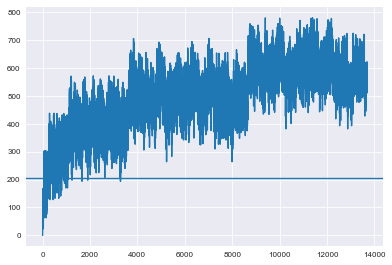

In [79]:
import matplotlib.pyplot as plt

plt.style.use(['seaborn-paper']) 
plt.plot(sum_arr)
plt.axhline(204)
plt.show()

$ Y_{ip} = 1 $ wenn Knoten i in Pfad p vorkommt 

$ C_p$ --> Kosten pro Pfad p

$ bigM $ für Zeitbeschränkung entfällt, weil ich Bedingung nur für anschließende Knoten definieren kann 

In [80]:
# Create P_ij
P = [[int(num) for num in sub] for sub in P]


paths=[]
P_pi = []
incidence = dict()
Con_pij = dict()
for c in P:
        paths.append((list([0]+c+[8])))
        #paths.append(c)
paths[0]

target = list('012345678')

for path_index,path in enumerate(paths):
    
    for cnt,pathelement in enumerate(path):
        if cnt > 0:
            #print(pathelement)
            incidence[path_index,int(rec_path)] = int(pathelement)
            Con_pij[path_index,int(rec_path),int(pathelement)] = 1
        rec_path = pathelement



In [81]:
P=paths[:]
P

[[0, 1, 8],
 [0, 2, 8],
 [0, 3, 8],
 [0, 4, 8],
 [0, 5, 8],
 [0, 6, 8],
 [0, 7, 8],
 [0, 1, 2, 8],
 [0, 1, 3, 8],
 [0, 1, 4, 8],
 [0, 1, 5, 8],
 [0, 1, 6, 8],
 [0, 1, 7, 8],
 [0, 2, 1, 8],
 [0, 2, 3, 8],
 [0, 2, 4, 8],
 [0, 2, 5, 8],
 [0, 2, 6, 8],
 [0, 2, 7, 8],
 [0, 3, 1, 8],
 [0, 3, 2, 8],
 [0, 3, 4, 8],
 [0, 3, 5, 8],
 [0, 3, 6, 8],
 [0, 3, 7, 8],
 [0, 4, 1, 8],
 [0, 4, 2, 8],
 [0, 4, 3, 8],
 [0, 4, 5, 8],
 [0, 4, 6, 8],
 [0, 4, 7, 8],
 [0, 5, 1, 8],
 [0, 5, 2, 8],
 [0, 5, 3, 8],
 [0, 5, 4, 8],
 [0, 5, 6, 8],
 [0, 5, 7, 8],
 [0, 6, 1, 8],
 [0, 6, 2, 8],
 [0, 6, 3, 8],
 [0, 6, 4, 8],
 [0, 6, 5, 8],
 [0, 6, 7, 8],
 [0, 7, 1, 8],
 [0, 7, 2, 8],
 [0, 7, 3, 8],
 [0, 7, 4, 8],
 [0, 7, 5, 8],
 [0, 7, 6, 8],
 [0, 1, 2, 3, 8],
 [0, 1, 2, 4, 8],
 [0, 1, 2, 5, 8],
 [0, 1, 4, 2, 8],
 [0, 1, 4, 3, 8],
 [0, 1, 4, 5, 8],
 [0, 1, 4, 6, 8],
 [0, 1, 4, 7, 8],
 [0, 1, 5, 2, 8],
 [0, 1, 5, 3, 8],
 [0, 1, 5, 4, 8],
 [0, 1, 7, 2, 8],
 [0, 1, 7, 4, 8],
 [0, 1, 7, 5, 8],
 [0, 1, 7, 6, 8],
 [0, 2, 1, 4, 8]

In [82]:
no = 2
K = 6
i = 8
n = 8
NO = 2
t_ipkn = []
for p in range(len(P)):
    for i in range(0,n+1):
        if i in P[p]:
                #print((p,i))
            #j = incidence[p,i,j]
                for k in range(K):
                    for no in range(NO):
                        t_ipkn.append((i,p,k,no))

In [83]:
s_pkn = []
for p in range(len(P)):
        if i in P[p]:
                #print((p,i))
            #j = incidence[p,i,j]
                for k in range(K):
                    for no in range(NO):
                        s_pkn.append((p,k,no))

In [84]:
t_ipkn[1]

(0, 0, 0, 1)

In [85]:
for asd in t_ipkn[0:2]:
    print(asd)

(0, 0, 0, 0)
(0, 0, 0, 1)


## Warm start

In [86]:
xval=dict()
tval=dict()
yval=dict()


def var2val (vars,tvar,yvar):
    for key,val in vars.iteritems():
        xval[key] = float(val.X)

    for key,val in tvar.iteritems():
        tval[key] = float(val.X)

    for key,val in yvar.iteritems():
        yval[key] = float(val.X)
    return xval,tval,yval



In [87]:
prodmenge = [150,100,80,60]

Optimize a model with 5744 rows, 3401 columns and 24130 nonzeros
Variable types: 1200 continuous, 2201 integer (2201 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [2e-01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 739000
Presolve removed 1576 rows and 1819 columns
Presolve time: 0.40s
Presolved: 4168 rows, 1582 columns, 14914 nonzeros
Variable types: 108 continuous, 1474 integer (1474 binary)

Root relaxation: objective 2.317667e+04, 1353 iterations, 0.19 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 23176.6667    0  180 739000.000 23176.6667  96.9%     -    2s
H    0     0                    621859.33333 23176.6667  96.3%     -    2s
     0     0 23176.6667    0  204 621859.333 23176.6667  96.3%     -    2s
     0     0 23176.6667    0  216 621859.333 231

H   28    27                    2243996.6667 23270.0000  99.0%  1399  156s
    42    42 25974.9799   17 1558 2243996.67 23270.0000  99.0%  1064  160s
    51    50 25974.9799   20 1177 2243996.67 23270.0000  99.0%   928  165s
    82    75 26886.7598   31  759 2243996.67 23270.0000  99.0%   732  170s
H   83    76                    1209155.6667 23270.0000  98.1%   723  170s
   114   100 28670.9720   42  506 1209155.67 23270.0000  98.1%   641  175s
H  141   119                    851741.83333 23270.0000  97.3%   615  179s
   143   121 23897.8856    6 1030 851741.833 23270.0000  97.3%   611  180s
H  168   143                    842443.50000 23270.0000  97.2%   594  183s
   179   155 23900.9975   23  674 842443.500 23270.0000  97.2%   615  186s
   194   169 infeasible   27      842443.500 23270.0000  97.2%   630  190s
H  197   170                    763541.16667 23270.0000  97.0%   642  190s
   220   185 25730.0455   37  686 763541.167 23270.0000  97.0%   674  195s
H  224   185             

H 2501  1425                    61290.166667 23626.3762  61.5%   726  861s
H 2565  1436                    43416.166667 23626.3762  45.6%   718  872s
  2771  1527     cutoff  324      43416.1667 23626.3762  45.6%   679  885s
H 2794  1523                    42588.833333 23713.3436  44.3%   682  885s
  2814  1544 25628.1534   37  945 42588.8333 23724.0350  44.3%   684  899s
  2885  1580 25309.7925   28  795 42588.8333 23724.6082  44.3%   689  913s
  2950  1638 infeasible   60      42588.8333 23727.4082  44.3%   693  928s
H 2983  1659                    42383.666667 23727.4082  44.0%   696  928s
  3013  1680 24332.9494   30  871 42383.6667 23727.4082  44.0%   704  945s
H 3030  1593                    40394.000000 23727.4082  41.3%   711  945s
  3056  1602 infeasible   38      40394.0000 23727.4082  41.3%   720  960s
H 3116  1644                    40178.166667 23727.4082  40.9%   728  977s
  3173  1660 24071.9867   27 1200 40178.1667 23775.4078  40.8%   741  994s
  3271  1724 24504.9162  

 14792 10348 33429.9638  195 2825 37711.3333 25660.0000  32.0%   686 4805s
 14793 10348 29409.5833   70 2622 37711.3333 25660.0000  32.0%   686 4811s
 14794 10349 28096.7578   33 2712 37711.3333 25660.0000  32.0%   686 4834s
 14795 10350 30123.5324   96 2309 37711.3333 25660.0000  32.0%   686 4844s
 14796 10350 26859.2581   52 2178 37711.3333 25660.0000  32.0%   686 4867s
 14797 10351 26228.6759   54 2388 37711.3333 25660.0000  32.0%   686 4873s
 14798 10352 27404.8333   47 2372 37711.3333 25660.0000  32.0%   686 4887s
 14799 10352 25660.0000   44 2487 37711.3333 25660.0000  32.0%   686 4898s
 14800 10353 26266.6239   32 2515 37711.3333 25660.0000  32.0%   686 4912s
 14801 10354 25660.0000   38 2487 37711.3333 25660.0000  32.0%   686 4923s
 14802 10354 27524.7467   54 2619 37711.3333 25660.0000  32.0%   686 4938s
 14803 10355 31628.0844   75 2226 37711.3333 25660.0000  32.0%   686 4956s
 14804 10356 26787.1213   37 2545 37711.3333 25660.0000  32.0%   685 4979s
 14805 10356 28078.6228  

 14903  9900 31628.0844   75 2010 37481.6667 25660.0000  31.5%   681 6037s
 14904  9900 26787.1213   37 2029 37481.6667 25660.0000  31.5%   681 6052s
 14906  9902 37481.6667  246 2008 37481.6667 25660.0000  31.5%   681 6068s
 14907  9902 25660.0000   20 2020 37481.6667 25660.0000  31.5%   681 6070s
 14908  9903 25926.8985   27 1901 37481.6667 25660.0000  31.5%   681 6081s
 14910  9904 30597.3223   96 1867 37481.6667 25660.0000  31.5%   681 6094s
 14911  9905 29056.0891   68 1767 37481.6667 25660.0000  31.5%   681 6096s
 14912  9906 33429.9638  195 1691 37481.6667 25660.0000  31.5%   681 6110s
 14913  9906 29409.5833   70 1490 37481.6667 25660.0000  31.5%   680 6123s
 14914  9907 28096.7578   33 1526 37481.6667 25660.0000  31.5%   680 6138s
 14915  9908 30123.5324   96 2258 37481.6667 25660.0000  31.5%   680 6142s
 14916  9908 26859.2581   52 2248 37481.6667 25660.0000  31.5%   680 6159s
 14917  9909 26228.6759   54 1915 37481.6667 25660.0000  31.5%   680 6177s
 14918  9910 27404.8333  

 21843 12468 25706.4179   44 1221 34898.8333 25680.6712  26.4%   951 14753s
 21936 12520 27326.9043   97 1048 34898.8333 25681.0787  26.4%   954 14932s
 22205 12662 26344.4967   50 1014 34898.8333 25681.7175  26.4%   958 15107s
 22415 12781 25765.2606   49 1670 34898.8333 25681.7175  26.4%   960 15274s
 22649 12907 26078.6933   87 1138 34898.8333 25682.5989  26.4%   962 15441s
 22839 13003 27823.1422   51  687 34898.8333 25683.1754  26.4%   968 15600s
 22967 13051 25862.8573   52 1720 34898.8333 25683.1754  26.4%   975 15760s
 23093 13116 infeasible   71      34898.8333 25683.5955  26.4%   984 15923s
 23346 13250 25759.9106   33 1622 34898.8333 25684.4766  26.4%   989 16063s
 23492 13314 27088.4524   66 1446 34898.8333 25684.4766  26.4%   994 16224s
 23724 13445 31850.3168  217  641 34898.8333 25686.2817  26.4%   996 16384s
 24196 13714 27381.0310   85 1272 34898.8333 25687.2222  26.4%   993 16545s
 24342 13790 26169.3870   36 1211 34898.8333 25687.4357  26.4%  1001 16702s
 24416 13796

 40116 21317 25826.5421   32 1841 34807.0000 25718.7222  26.1%  1383 32575s
 40306 21424 30325.3438   98 1098 34807.0000 25718.7222  26.1%  1386 32737s
 40416 21469 26911.0043   67  855 34807.0000 25719.0844  26.1%  1389 32900s
 40620 21620 26266.8558   40 2248 34807.0000 25719.4946  26.1%  1394 33133s
 40707 21683 26696.3747   41 1555 34807.0000 25719.4946  26.1%  1396 33278s
 40802 21762 27897.0845   56 1437 34807.0000 25719.4946  26.1%  1400 33437s
 40904 21827 infeasible   60      34807.0000 25719.4946  26.1%  1406 33600s
 41081 21974 29667.3926   96 1381 34807.0000 25721.0568  26.1%  1409 33759s
 41144 22018 27306.2709   84 1203 34807.0000 25721.3217  26.1%  1413 33919s
 41422 22271 infeasible   51      34807.0000 25721.3456  26.1%  1414 34071s
 41576 22393 29302.9767  119 1206 34807.0000 25721.5444  26.1%  1416 34241s
 41959 22730 27806.6870   96 1273 34807.0000 25721.6667  26.1%  1412 34403s
 42196 22937 27137.2640   56 1217 34807.0000 25722.3245  26.1%  1412 34557s
 42318 23031

 62138 39985 28224.9111   69 1765 34730.5000 25735.3731  25.9%  1527 48779s
 62209 40043 27266.6750   60 1354 34730.5000 25735.3731  25.9%  1532 48936s
 62363 40168 27376.2825   73 1429 34730.5000 25735.5869  25.9%  1534 49086s
 62563 40340 25861.0652   47 1972 34730.5000 25735.5869  25.9%  1536 49248s
 62863 40595 26972.5752   57 1131 34730.5000 25735.5869  25.9%  1534 49389s
 63095 40800 28843.7055  114 1178 34730.5000 25736.1153  25.9%  1535 49551s
 63455 41117 27264.4611   78 1682 34730.5000 25736.1153  25.9%  1533 49704s
 63666 41301 27420.5132   89 1699 34730.5000 25736.3167  25.9%  1532 49867s
 64097 41688 25960.7752   56 1633 34730.5000 25736.3167  25.9%  1529 50023s
 64141 41720 29091.7307   95 1245 34730.5000 25736.3167  25.9%  1530 50177s
 64422 41979 26655.7678   36  790 34730.5000 25736.3167  25.9%  1529 50317s
 64573 42115 31461.7021  108  695 34730.5000 25736.3556  25.9%  1531 50475s
 64945 42435 26379.7475   42 1133 34730.5000 25736.6500  25.9%  1528 50614s
 65297 42735

 86704 61235 26286.5717   68  848 34730.5000 25748.6432  25.9%  1547 63855s
 86916 61400 27098.8545   57 1199 34730.5000 25748.7832  25.9%  1548 63993s
 87356 61802 28342.9390   75  961 34730.5000 25748.9003  25.9%  1544 64117s
 87664 62045 26110.4294   51 1372 34730.5000 25749.0340  25.9%  1543 64237s
 87771 62132 25974.4292   49 1708 34730.5000 25749.2148  25.9%  1544 64363s
 87992 62330 25936.6454   84 1034 34730.5000 25749.3402  25.9%  1545 64510s
 88305 62607 25815.2370   29 1585 34730.5000 25749.3978  25.9%  1543 64625s
 88490 62757 26850.2407   32 1744 34730.5000 25749.3978  25.9%  1543 64750s
 88574 62829 27200.1667   34 1369 34730.5000 25749.3978  25.9%  1544 64865s
 88648 62873 27283.8472   37 1677 34730.5000 25749.6722  25.9%  1546 64985s
 88752 62943 25964.5889   45 1163 34730.5000 25749.7727  25.9%  1548 65107s
 88987 63161 27445.6390   70 1061 34730.5000 25749.7727  25.9%  1548 65232s
 89258 63392 31206.0225  170  716 34730.5000 25749.9188  25.9%  1547 65365s
 89586 63661

 110205 81168 26514.7260  126 1244 34730.5000 25760.7667  25.8%  1604 76442s
 110485 81355 25923.1110   55 1015 34730.5000 25760.8691  25.8%  1604 76548s
 110647 81495 29468.3642  129 1022 34730.5000 25760.9208  25.8%  1605 76644s
 110734 81569 27765.1997   88  844 34730.5000 25760.9208  25.8%  1606 76749s
 110918 81733 26447.5327   53 1317 34730.5000 25760.9208  25.8%  1607 76850s
 111050 81794 28025.9200  106 2067 34730.5000 25761.1240  25.8%  1608 76962s
 111231 81951 26219.7667   42 1239 34730.5000 25761.2701  25.8%  1609 77061s
 111347 82045 28568.8675   70 1240 34730.5000 25761.5701  25.8%  1611 77176s
 111482 82141 infeasible   63      34730.5000 25761.5938  25.8%  1613 77295s
 111738 82364 27647.5915   74 1233 34730.5000 25761.6667  25.8%  1615 77419s
 112158 82700 27395.9338   80 1065 34730.5000 25761.8035  25.8%  1615 77538s
 112672 83128 27305.5565   44 1252 34730.5000 25761.8204  25.8%  1612 77645s
 112887 83325 28393.8333   53  463 34730.5000 25761.8204  25.8%  1612 77752s

 131486 99165 27973.9908  102 1645 34730.5000 25771.2549  25.8%  1662 88524s
 131579 99239 30814.6667  127  975 34730.5000 25771.4771  25.8%  1662 88525s
 131787 99418 26122.8253   68  780 34730.5000 25771.9439  25.8%  1661 88638s
 132073 99650 28528.8007   73 1247 34730.5000 25772.1325  25.8%  1661 88749s
 132180 99737 27525.7649   73 1217 34730.5000 25772.1892  25.8%  1662 88859s
 132274 99821 infeasible  107      34730.5000 25772.6032  25.8%  1664 88970s
 132429 99944 26059.1642   50 1849 34730.5000 25772.6032  25.8%  1665 89089s
 132621 100103 27907.6812   97 1309 34730.5000 25772.8343  25.8%  1666 89215s
 132818 100265 26501.0819   62 1175 34730.5000 25772.8372  25.8%  1667 89339s
 132986 100407 30202.3713   97 1361 34730.5000 25772.9712  25.8%  1668 89470s
 133363 100744 25866.6526   49 2032 34730.5000 25773.0150  25.8%  1666 89601s
 133629 100984 27482.3172   86 1608 34730.5000 25773.2229  25.8%  1666 89730s
 133990 101292 31533.1401  160 1037 34730.5000 25773.3994  25.8%  1665 

 154030 118221 27482.7167   96  952 34730.5000 25782.1690  25.8%  1690 101368s
 154283 118437 25984.8729   51 1360 34730.5000 25782.2292  25.8%  1690 101519s
 154387 118526 30090.6630   90  895 34730.5000 25782.3063  25.8%  1691 101644s
 154768 118876 27883.4241   84  820 34730.5000 25782.3171  25.8%  1689 101771s
 155050 119131 26115.4844   30 1942 34730.5000 25782.3171  25.8%  1689 101898s
 155079 119157 26122.6246   39 1868 34730.5000 25782.3931  25.8%  1690 102030s
 155369 119416 30385.5357   52  814 34730.5000 25782.4000  25.8%  1690 102174s
 155596 119593 30989.5617  155  814 34730.5000 25782.5006  25.8%  1690 102320s
 155877 119836 27184.0180   67 1841 34730.5000 25782.5123  25.8%  1690 102453s
 155967 119917 28752.8192   82 1357 34730.5000 25782.5123  25.8%  1691 102578s
 156184 120105 34292.1909  151  813 34730.5000 25782.5345  25.8%  1691 102703s
 156374 120263 31139.2500   77  456 34730.5000 25782.6250  25.8%  1691 102832s
 156453 120328 infeasible   54      34730.5000 25782

 169481 131302 33660.7891  326 2673 34730.5000 25787.5236  25.7%  1700 111360s
 169483 131303 27946.9062   50 1837 34730.5000 25787.5236  25.7%  1700 111376s
 169485 131304 27482.7167   96 1954 34730.5000 25787.5236  25.7%  1700 111391s
 169486 131305 28028.3793  111 1954 34730.5000 25787.5236  25.7%  1700 111397s
 169487 131306 31469.3696   90 1982 34730.5000 25787.5236  25.7%  1700 111414s
 169488 131306 30614.9512  160 1808 34730.5000 25787.5236  25.7%  1700 111420s
 169489 131307 28964.8932   90 2305 34730.5000 25787.5236  25.7%  1700 111433s
 169490 131308 26380.1170   77 2131 34730.5000 25787.5236  25.7%  1700 111447s
 169491 131308 28454.2650   90 2535 34730.5000 25787.5236  25.7%  1700 111461s
 169492 131309 32678.5540  186 2426 34730.5000 25787.5236  25.7%  1700 111471s
 169493 131310 26822.1780   44 2269 34730.5000 25787.5236  25.7%  1700 111489s
 169494 131310 27109.3529   48 2375 34730.5000 25787.5236  25.7%  1700 111494s
 169495 131311 33390.8279  266 2332 34730.5000 25787

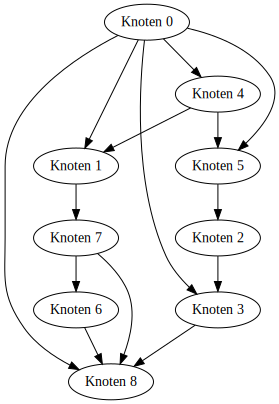

In [90]:
import sys
import math
import random
from gurobipy import *


################### Parameters ############################################################################

P = 1

K = 6


bigM=400
bigM2=50
routes = 1

M=10000




def model_run(routes,nJobs,warm_start = False,xval=None,tval=None,yval=None,bigM=300):



    ################### Decision Variables ############################################################################

    vars = {}
    for i in range(n+1):
        for j in range(0,n+1):
            if i!=j: #same index would mean nothing--> decreases amount of variables
                for r in range(routes):
                    for k in range(K):
                        vars[i, j,  k, r] = m.addVar(vtype=GRB.BINARY, name='x_'+
                                                     str(i)+'_'+str(j)+'_'+str(k)+'_'+str(r))
    #m.update()

    yvar = {}
    for i in range(n+1):
        #for njob in range(nJobs):
            for r in range(routes):
                for k in range(K):
                    yvar[i, k,  r] = m.addVar(vtype=GRB.BINARY, 
                                              name='y_'+str(i)+'_'+
                                              str(k)+'_'+str(r)) #lb=K, ub=L, vtype=GRB.INTEGER, name='u_'+str(i))

    tvar = {}
    for i in range(n+1):
        for r in range(routes): #R+1 ist wichtig fü
            for k in range(K): 
                tvar[i, k, r] = m.addVar(lb=0.0,vtype=GRB.CONTINUOUS,
                                         name='t_'+str(i)+'_'+str(k) + "_" + str(r))

    cvar={}

    for i in range(n+1):
        for njob in range(nJobs):
            if np.isnan(a.loc[i, njob]) == False: 
                for r in range(routes):
                    for k in range(K):
                        cvar[i, njob, k, r] = m.addVar(lb=0.0,vtype=GRB.CONTINUOUS,
                                                       name='c_'+str(i)+'_'+str(njob)+
                                                       '_'+str(k)+"_"+str(r))


    jvar={}

    for i in range(n+1):
        for njob in range(nJobs):
            for r in range(routes):
                for k in range(K):
                    jvar[i, njob, k, r] = m.addVar(vtype=GRB.BINARY,
                                                   name='j_'+str(i)+'_'+str(njob)+'_'+
                                                   str(k)+"_"+str(r))




    prodstartvar={}

    for r in range(routes):
        for k in range(K):
                prodstartvar[k, r] = m.addVar(lb=0.0,vtype=GRB.CONTINUOUS,
                                              name='prodt_'+str(k)+ "_" + str(r))

    carroutevar={}

    for r in range(routes):
        for k in range(K):
                carroutevar[k, r] = m.addVar(vtype=GRB.BINARY,
                                             name='carroute_'+str(k)+ "_" + str(r))


    prodrelvar={}

    for r in range(routes):
        for p in range(P):
            for t in range(T):
                for k in range(K):
                    prodrelvar[p,t,k,r] = m.addVar(vtype=GRB.BINARY,name='prodrel_'+
                                                   str(p)+'_'+str(t)+'_'+str(k)+"_"+str(r))


    prodreltypevar={}

    for r in range(routes):
        for p in range(P):
             for t in range(T):
                prodreltypevar[p,t,r] = m.addVar(vtype=GRB.BINARY,
                                                 name='prodreltype_'+str(p)+'_'+str(t)+"_"+str(r))


    mvar = {}

    for i in range(0,n):
        for njob in range(nJobs):
            if np.isnan(a.loc[i, njob]) == False: 

                mvar[i, njob] = m.addVar(vtype=GRB.BINARY,
                                         name='m_'+str(i)+'_'+str(njob))
                
                
    linevar = {}
    for p in range(P):
        linevar[p] = m.addVar(vtype=GRB.BINARY,  name='lvar_'+str(p))
        
        
    ################### Constraints ############################################################################

    m.update()

    ### flow constraints #######################

    
    for r in range(routes): # all routes start point -> 0
        for k in range(K):
            m.addConstr(quicksum(vars[0, i, k, r] for i in range(1, n+1)) == 1,'1st')

    for r in range(routes): # all routes end point -> n+1
        for k in range(K):
            m.addConstr(quicksum(vars[i, n, k, r] for i in range(0, n)) == 1, '2nd') #!!!!! Python range(0,3)-> 0,1,2 ; n means here n+1

    for h in range(1,n): # all arcs in = all arcs out
        for r in range(routes):
            for k in range(K):
                m.addConstr(quicksum(vars[i, h, k, r] for i in range(n) if i != h ) -
                            quicksum(vars[h, j, k, r] for j in range(0,n+1) if j != h )  == 0 , '3rd')

    ################
    for i in range(0,n): #specifies if job $njob$ from node $i$ is in route $r,k$ 
        for r in range(routes):
            for k in range(K):
                m.addConstr(quicksum(vars[i, j, k,  r] for j in range(0, n+1) if i !=j  ) -
                        yvar[i, k, r]   == 0 , '5th')


    #### time constraints ##############################################

    for i in range(0,n+1): 
        for j in range(0,n+1):
            if i!=j:
                for r in range(routes):
                    for k in range(K):
                        m.addConstr(tvar[i, k, r] + T_ij[i][j]  - bigM *(1 - vars[i, j, k, r] ) <= tvar[j, k, r], '6th')
                        #m.addConstr(tvar[i, k, r] <= yvar[i, k, r] * bigM, '7th') #tightness purposes


    for r in range(routes):
        for k in range(K): #each prodlinetype for one k,r --> simplification
            m.addConstr(quicksum(prodrelvar[p,t,k,r] for t in range(T) for p in range(P) )  == 1, "10th")

    for r in range(routes): 
        for k in range(K):
            m.addConstr(prodstartvar[k,r] + quicksum(prodrelvar[p,t,k,r] * proddur[t] for t in range(T) for p in range(P)  )
                        <= tvar[0,k, r], "11th")

    for i in range(0,n):  #amin_im*y_imr <= t_ir <= amax_im*y_imr --> two sided constraint splitted in both sides
                for r in range(routes):      
                    for k in range(K):
                        for njob in range(nJobs):
                            if np.isnan(a.loc[i, njob]) == False: #do not create constraints for NaN values

                                m.addConstr((a.loc[i, njob] - tvar[0,k,r] >= quicksum(prodrelvar[p,t,k,r] * mins[t] for t in range(T) for p in range(P)  ) 
                                            - 500 * (1-jvar[i,njob,k,r])  ) ,'12th')
                                m.addConstr(a.loc[i, njob] - tvar[0,k,r] <= quicksum(prodrelvar[p,t,k,r] * maxs[t] for t in range(T) for p in range(P)  ) 
                                            + 500 * (1-jvar[i,njob,k,r]) ,'12bth')                    

    for i in range(1,n): 
        for njob in range(nJobs):
            if np.isnan(a.loc[i, njob]) == False:
                for r in range(routes):
                    for k in range(K):
                        m.addConstr( cvar[i, njob,k, r] >= tvar[i,k, r] - M * (1-jvar[i,njob,k,r]), '14th')
                        m.addConstr( cvar[i, njob,k, r] <=  a.loc[i, njob]- 30.0 - S_j[i]   , '15th')
    '''
    for i in range(1,n): 
        for r in range(routes):
            for k in range(K):
                m.addConstr( quicksum(jvar[i, njob, k,r] for njob in range(nJobs) if np.isnan(a.loc[i, njob]) == False) 
                        >= yvar[i,k, r], '16th')

    '''
    for njob in range(nJobs):
        if np.isnan(a.loc[i, njob]) == False:
            for i in range(1,n):
                m.addConstr( quicksum(jvar[i, njob,k, r] for r in range(routes) for k in range(K)) 
                        <= 1, '17th')

    for njob in range(nJobs):
        if np.isnan(a.loc[i, njob]) == False:
            for i in range(1,n):
                for r in range(routes):
                    for k in range(K):
                        m.addConstr( jvar[i, njob,k, r]  <= yvar[i, k,r] , '18th')

    for i in range(1,n): 
        for njob in range(nJobs):
            if np.isnan(a.loc[i, njob]) == False:
                #for r in range(routes):
                    m.addConstr(mvar[i, njob] 
                                + quicksum(jvar[i, njob,k, r] for r in range(routes) for k in range(K))== 1 , '19th') #either n-th job is delivered or penalty variable is true (1)

    for r in range(routes-1):
        for k in range(K):
            m.addConstr(tvar[n,k,r] <= tvar[0,k,r+1],"20th")


    for r in range(route): # empty route?
        for k in range(K):
            m.addConstr(carroutevar[k,r] == quicksum(vars[0,j,k,r]  for j in range(1,n) ) ,"21th")

    
 
    for p in range(P):
        m.addConstr(quicksum(prodrelvar[p,t,k,r] for r in range(routes) for k in range(K) for t in range(T)  )  <= 10000 * linevar[p], "22th")

    
    for r in range(routes): 
        for k in range(K):
            m.addConstr(quicksum(prodrelvar[p,t,k,r] * 
                        prodmenge[t] for p in range(P) for t in range(T) ) >= quicksum(jvar[i,njob,k,r] for i in range(n) for njob in range(nJobs) 
                                                 if np.isnan(a.loc[i, njob]) == False))
                       
                    
    ################### Objective function ########################################################################

    m.update()

    obj = ( 

        ######## Distribution ###############################################################
        quicksum( c_ij[i][j] * vars[i,j,k,r] for i in range(n)  # Entfernungskosten
                        for j in range(1,n+1) for r in range(routes) for k in range(K) if i!=j)

            + 1000.00 * quicksum(carroutevar[k,r] for k in range(K) for r in range(routes))

            + (10.0 / 60.0 ) * quicksum(tvar[n,k,r] - tvar[0,k,r]   
                                    for k in range(K) for r in range(routes) ) # Stundensatz pro Auto

         ######## Strafkosten ###############################################################
            + M * quicksum( mvar[i, njob]  
                        for i in range(0,n) for njob in range(nJobs) if np.isnan(a.loc[i, njob]) == False)

         ######## Produktion ###############################################################
            +  1200.0 * quicksum(prodrelvar[p,t,k,r] * proddur[t] for t in range(T) for p in range(P)  ) 
            
            + 3000 * quicksum(linevar[p] for p in range(P))
        )

    m.setObjective(obj)


    ################### Run Model ############################################################################

    m.write("mtsp.lp")
    m.write("mtsp.mps")

    m._vars = vars


    ############ Solver Strategy
    #m.Params.MIPFocus=1 #best objectie bound is moving slowly

    if warm_start == True:
        for key,val in xval.iteritems():
            vars[key].start = float(val)
            
        for key,val in tval.iteritems():
            tvar[key].start = float(val)
            
        for key,val in yval.iteritems():
            yvar[key].start = float(val)

    m.optimize()

    status = m.status


    ################### Error Handling ############################################################################

    if status == GRB.Status.UNBOUNDED:
        print('The model cannot be solved because it is unbounded')
    if status == GRB.Status.OPTIMAL:
        print('The optimal objective is %g' % m.objVal)
    if status != GRB.Status.INF_OR_UNBD and status != GRB.Status.INFEASIBLE:
        print('Optimization was stopped with status %d' % status)
    else:
        # do IIS
        print('The model is infeasible; computing IIS')
        m.computeIIS()
        print('\nThe following constraint(s) cannot be satisfied:')
        for c in m.getConstrs():
            if c.IISConstr:
                print('%s' % c.constrName)

        m.write('infeasible.ilp')

        m.feasRelaxS(1, False, False, True) #calculate relaxed solution
        m.printAttr('x1', 'Art*')
        m.optimize()
    #print(vars)
    return vars, tvar, yvar,mvar,cvar,jvar,prodrelvar

    
m = Model()
vars,tvar,yvar,_,_,_,_ = model_run(routes=2,nJobs=10,bigM=200)
xval,tval,yval = var2val(vars,tvar,yvar)

m = Model()
vars,tvar,yvar,mvar,cvar,jvar,prodrelvar = model_run(routes=4,nJobs=47,warm_start=True,xval = xval,tval = tval,yval = yval,bigM=400)
solution = m.getAttr('x', vars)
selected=[vals for vals in solution if solution[vals]>0]

print('')
print('Optimal tour: %s' % str(selected))
print('Optimal cost: %g' % m.objVal)
print('')
x,mdf,y,t,c,j,prodrel=printvars2()

uniquevals=np.vstack({tuple(row) for row in np.array(selected)[:,:2]}).tolist() #unique i,j combinations for plotting
plotdigraph(uniquevals)




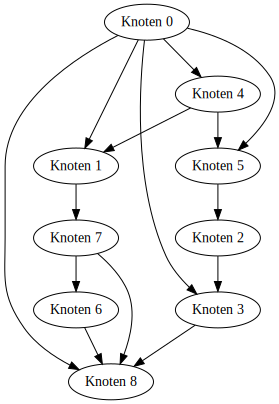

In [94]:
plotdigraph(uniquevals)